# PTM PPI Shortcut analysis

In [1]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree
from pyirr import kappa2

sys.path.append("../src")
from utils.s3_utils import download_file



all_labels = list(range(7))
pos_labels = list(range(1,7,1))
label_names = ["other",
                            "phosphorylation",
                            "dephosphorylation",
                            "methylation",
                            "ubiquitination",
                            "acetylation",
                            "deubiquitination"]

renamed_labels = ["Negative"] + [i.title() for i in label_names[1:]]

ptm_trigger_words =  ["phosphorylation", "deubiquitination", "acetylation", "ubiquitination", "methylation", "dephosphorylation"]



## Original inputs with markers
For how to create the preprocessed file for PTM-PPI, see https://github.com/elangovana/large-scale-ptm-ppi/blob/main/src/utils/static_markers_ppi_multiclass.py

In [2]:
temp_dir = "temp"

In [3]:
trainfile="../temp/markers_train_multiclass.json"
testfile="../temp/markers_test_multiclass.json"
valfile="../temp/markers_val_multiclass.json"


In [4]:
s3_generalisation = "s3://aegovan-data/pubmed_asbtract/predictions_largescale_ppimulticlass-bert-f1-2021-05-10-10_2022-07-01_negative_generalisation/"
s3_large_scale_high_q = "{}/highquality_sample.json".format(s3_generalisation.rstrip("/"))
s3_large_scale_low_q = "{}/lowquality_sample.json".format(s3_generalisation.rstrip("/"))

## Predictions with markers

In [5]:
largescalefile = "../temp/markers_largescale_hq_above_threshold.json"
largescale_low_hq="../temp/markers_largescale_lq_below_threshold.json"

test_predictions_file ="../temp/markers_test_pred_multiclass.json"

In [6]:
def load_large_scale(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]
    

    return df

def load_valtest_ensemble_pred(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

In [7]:
from model_nb_relation_classifier import ModelNBRelationClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier
from model_tree_relation_classifier import ModelTreeRelationClassifier

NAIVE_BAYES="Naive Bayes"
NAIVE_BAYES_WITH_TREE = "Naive Bayes + Tree"
TREE = "Tree"


    
     

def  train_and_predict_all_classifiers(df, min_df=None, ngram_range=(1,1), stop_words = 'english', classifiers={NAIVE_BAYES, NAIVE_BAYES_WITH_TREE}, max_words_per_class = 100, classwise_vocab=True):
    
    max_tree_depth = 4
 
    
   
    
    classifiers_map = {
        NAIVE_BAYES : ModelNBRelationClassifier( min_df=min_df, max_words_per_class=max_words_per_class, stop_words=stop_words, ngram_range=ngram_range, classwise_vocab=classwise_vocab),
        NAIVE_BAYES_WITH_TREE : ModelNBTreeRelationClassifier("PROTPART1", "PROTPART0",  min_df=min_df,  max_words_per_class=max_words_per_class, stop_words=stop_words, ngram_range=ngram_range, classwise_vocab=classwise_vocab, trigger_words=ptm_trigger_words, max_tree_depth = max_tree_depth ),
 #      TREE : ModelTreeRelationClassifier("PROTPART1", "PROTPART0",  trigger_words=ptm_trigger_words, max_tree_depth=max_tree_depth)

    }
   
    
    result = {}
    
    for k in filter(lambda x: x in classifiers,  classifiers_map):
    
        m = classifiers_map[k]
        
        print(f"Training {k}")
        
        m.train(df["x"], df["y"])
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result



def  predict_all_classifiers(df, models_dict):
    max_words_per_class = 10
    max_tree_depth = 4
    
   
    
    result = {}
    for k, v in models_dict.items():
        m = v["m"]
        
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result


In [8]:
def isint(a):
    try:
        t = int(a)
        return True
    except:
        return False
    
def float_percent_format(x):
     return "{:.1f}".format(x*100)

def int_format(x):
     return str(int(x))
    
def float_format(x):
     return "{:.2f}".format(x)
    
def compute_kappa(r1, r2):
    python_kappa = sklearn.metrics.cohen_kappa_score(r1,r2)
    print(python_kappa)
    data = {'r1': r1,
        'r2': r2}

    df = pd.DataFrame(data)
    r_kappa = kappa2(df, weight="equal")
    print(r_kappa)
    
    result = {
        "python_kappa" : python_kappa,
        "r_kappa" : r_kappa.value,
        "r_pvalue":r_kappa.pvalue
        
    }
    return result

def print_report(actual, pred, labels=None, label_names = renamed_labels):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    
        
    d = sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=True,
                                            labels=labels,zero_division=0)
    
    k_scores = compute_kappa(actual, pred )
    for k, v in k_scores.items():
        d[k] = {
            "cohen" : v,
            "support" : len(actual),

        }
        
    df =  pd.DataFrame(d).T
    df.index = list(map(lambda x: label_names[int(x)] if isint( x) else x, df.index))
    df.insert(1, "index", df.index)


    return df
    
def print_report_all_classifiers(actual, results_dict, *args, **kwargs):
    result = []
    for k, v in results_dict.items():
        df = print_report(actual,v["predictions"],  *args, **kwargs)
        df.insert (0, "model", k)
        
        result.append(df)
    df = pd.concat(result)
    print(df.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format }))
    return df
        
        

In [9]:
def prep_data(df, m):
    df_t = df.copy(deep=True)
    df_t["nb_pred"] = m["predictions"]
    df_t["nb_pred_conf"] = m["predictions_conf"]
    df_t["nb_pred_raw"] = df_t["nb_pred"].apply(lambda i: label_names[i])
    return df_t

def plot_confidence(df_t):
    labels =  list(df_t["y_raw"].unique())   
    print(labels)
    _ , ax = plt.subplots(len(labels),1, figsize=(10,15))



    for i,l in enumerate(labels):
        t = df_t.query(f"y_raw == '{l}'")

        ax[i].set_ylim(0,1)


        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')



        ax[i].violinplot(t["confidence"],  showmeans=True )
        ax[i].set_title(f"{l}")


# plot_confidence(prep_data(df_largescale_hq, result_largescale_hq[NAIVE_BAYES_WITH_TREE]))

# plt.show()




In [10]:
from dtreeviz.trees import *

def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names, filled=True, rounded=True)

    plt.show()
    
def plot_tree_pretty(m, x, y, title="", image_save_path=None):
    import sys
    dot_path = '/opt/homebrew/bin/'
    if dot_path not in sys.path :
        sys.path.append( dot_path)
        for p in sys.path:
            os.environ["PATH"] = os.environ.get("PATH","") + ":" +  p

    viz = dtreeviz(m.tree_model,
               x_data=m.extract_features(x),
               y_data=y,
               target_name='class',
               feature_names=m.feature_names,
               class_names=label_names,
               title=title)
    
    # tree_plt.view()    
    if image_save_path:
        viz.save(image_save_path)
        
    return viz



In [11]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}
    
    #. ( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])]

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])[:50]




In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")
    

## Train GT Train predictions

In [13]:
def transform_ovr(df):
    """
    Transform into one-vs-all
    """
    # Phosphorylation
    target_pos_label=1

    df["y"] = df["y"].apply(lambda x: 1 if x == target_pos_label else 0)
    df["y_raw"] = df["y"].apply(lambda x: label_names[x])


    return df

In [14]:
df_train = pd.read_json(trainfile, orient="records").pipe(transform_ovr)
train_result = train_and_predict_all_classifiers(df_train)

print_report_all_classifiers(df_train["y"], train_result,  pos_labels)

print_report_all_classifiers(df_train["y"], train_result,  all_labels)



Training Naive Bayes
Max words :  117
Training Naive Bayes + Tree
Max words :  117
Extracting features..for 1305
Completed..
0.32908122073308577
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 1305
  Raters = 2
   Kappa = 0.329

       z = 13.785
 p-value = 0.000

0.5426661068760561
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 1305
  Raters = 2
   Kappa = 0.543

       z = 19.855
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &             index & recall & f1-score & support &    cohen \\
\midrule
       Naive Bayes &      30.2 &   Phosphorylation &   75.5 &     43.1 &     139 &      NaN \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 &      NaN \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 &      NaN \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 &      NaN \\
       Naive Bayes &       0.0 &       Acetylation

,model,precision,index,recall,f1-score,support,cohen
Negative,Naive Bayes,0.964472,Negative,0.791595,0.869524,1166.0,NaN
Phosphorylation,Naive Bayes,0.301724,Phosphorylation,0.755396,0.431211,139.0,NaN
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0,NaN
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0,NaN
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0,NaN
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0,NaN
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0,NaN
micro avg,Naive Bayes,0.787739,micro avg,0.787739,0.787739,1305.0,NaN
macro avg,Naive Bayes,0.180885,macro avg,0.220999,0.185819,1305.0,NaN
weighted avg,Naive Bayes,0.893881,weighted avg,0.787739,0.822838,1305.0,NaN


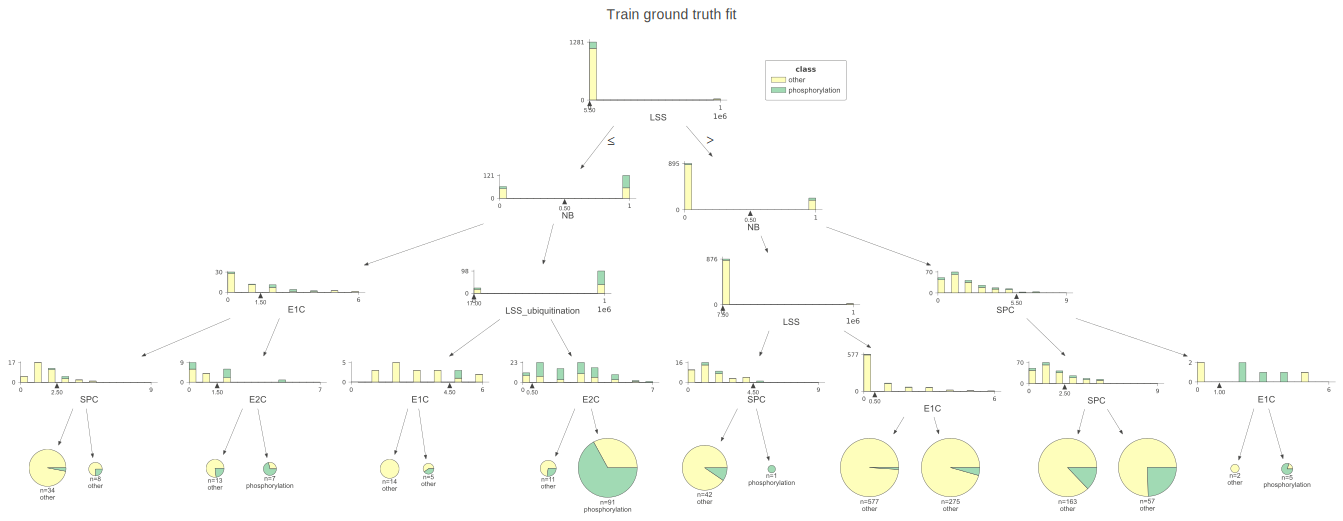

In [15]:
#plot_tree(train_result[NAIVE_BAYES_WITH_TREE]["m"])

plot_tree_pretty(train_result[NAIVE_BAYES_WITH_TREE]["m"], df_train["x"], df_train["y"], "Train ground truth fit",  "train_gt_fit_tree.svg" )

In [16]:
get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],0)

[('prtig0', -2.6724640929518895),
 ('protpart1', -2.747599517435523),
 ('protpart0', -2.7557278078412786),
 ('prtig1', -2.8522856484437593),
 ('prtig2', -3.067037542121721),
 ('prtig3', -3.2399329132351298),
 ('phosphorylation', -3.284317783936645),
 ('cells', -3.788753609603865),
 ('protein', -3.838372142253456),
 ('kinase', -3.856609729803237),
 ('prtig4', -3.8905818008541457),
 ('activation', -3.8997919261783727),
 ('cell', -4.067558008023628),
 ('induced', -4.2995792333698555),
 ('tyrosine', -4.305969031468627),
 ('activity', -4.350760789671363),
 ('phosphorylated', -4.4679853221018355),
 ('proteins', -4.473023116131793),
 ('signaling', -4.629913235033944),
 ('binding', -4.672151791242128),
 ('kinases', -4.714644415207039),
 ('results', -4.735766240236321),
 ('dependent', -4.762390108948493),
 ('domain', -4.764077873062213),
 ('expression', -4.800195298290208),
 ('response', -4.800195298290208),
 ('complex', -4.807225204218467),
 ('prtig5', -4.850475188012283),
 ('vitro', -4.854165

In [17]:
get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],1)

[('protpart1', -2.1270536181418374),
 ('protpart0', -2.2446993005942417),
 ('prtig0', -3.008253030204722),
 ('phosphorylation', -3.2569184503140516),
 ('prtig1', -3.26717495048124),
 ('kinase', -3.6830028456249515),
 ('prtig2', -3.804699780602471),
 ('cells', -3.8529018824203494),
 ('protein', -3.8842524123044253),
 ('cell', -4.050149089430979),
 ('activation', -4.050149089430979),
 ('activity', -4.128313862280316),
 ('phosphorylated', -4.161374724541203),
 ('induced', -4.386621326052192),
 ('tyrosine', -4.463161403174526),
 ('prtig3', -4.50968141880942),
 ('binding', -4.583789390963141),
 ('human', -4.6778183406114175),
 ('vitro', -4.706391713055473),
 ('response', -4.750843475626308),
 ('signaling', -4.750843475626308),
 ('domain', -4.766110947757096),
 ('proteins', -4.7973634912612),
 ('kinases', -4.813363832607641),
 ('results', -4.862960773747013),
 ('dna', -4.880055207106314),
 ('complex', -4.880055207106314),
 ('expression', -4.897446949818183),
 ('dependent', -4.915146526917583

In [18]:
compute_kappa(df_train["y"], train_result[NAIVE_BAYES]["predictions"] )

0.32908122073308577
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 1305
  Raters = 2
   Kappa = 0.329

       z = 13.785
 p-value = 0.000



{'python_kappa': 0.32908122073308577,
 'r_kappa': 0.3290812207330856,
 'r_pvalue': 0.0}

In [19]:
compute_kappa(df_train["y"],  train_result[NAIVE_BAYES_WITH_TREE]["predictions"] )

0.5426661068760561
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 1305
  Raters = 2
   Kappa = 0.543

       z = 19.855
 p-value = 0.000



{'python_kappa': 0.5426661068760561,
 'r_kappa': 0.5426661068760562,
 'r_pvalue': 0.0}

## Val GT predictions


In [20]:
df_val = pd.read_json(valfile, orient="records").pipe(transform_ovr)
result_val = train_and_predict_all_classifiers(df_val, min_df=1)

print_report_all_classifiers(df_val["y"], result_val,  pos_labels)

print_report_all_classifiers(df_val["y"], result_val,  all_labels)



Training Naive Bayes
Max words :  138
Training Naive Bayes + Tree
Max words :  138
Extracting features..for 200
Completed..
0.2795830778663396
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 200
  Raters = 2
   Kappa = 0.280

       z = 4.685
 p-value = 0.000

0.5241581259150805
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 200
  Raters = 2
   Kappa = 0.524

       z = 8.428
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &             index & recall & f1-score & support &    cohen \\
\midrule
       Naive Bayes &      26.8 &   Phosphorylation &   71.4 &     39.0 &      21 &      NaN \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 &      NaN \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 &      NaN \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 &      NaN \\
       Naive Bayes &       0.0 &       Acetylation &    

,model,precision,index,recall,f1-score,support,cohen
Negative,Naive Bayes,0.958333,Negative,0.770950,0.854489,179.0,NaN
Phosphorylation,Naive Bayes,0.267857,Phosphorylation,0.714286,0.389610,21.0,NaN
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0,NaN
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0,NaN
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0,NaN
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0,NaN
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0,NaN
micro avg,Naive Bayes,0.765000,micro avg,0.765000,0.765000,200.0,NaN
macro avg,Naive Bayes,0.175170,macro avg,0.212176,0.177729,200.0,NaN
weighted avg,Naive Bayes,0.885833,weighted avg,0.765000,0.805677,200.0,NaN


## Test 

In [21]:
pd.read_json(testfile, orient="records").head()

,x,y,y_raw
0,Cellular responses to DNA damage require the f...,1,phosphorylation
1,Cellular responses to DNA damage require the f...,1,phosphorylation
2,PRTIG2 is a key activator of inflammatory and ...,3,methylation
3,PROTPART1-specific activity has been reported ...,2,dephosphorylation
4,Maintenance of chromosomal stability relies on...,1,phosphorylation


### Predict Test on Test GT fit

In [22]:
df_test = pd.read_json(testfile, orient="records").pipe(transform_ovr)
result_test_gt = train_and_predict_all_classifiers(df_test, min_df=1)

# df_test["train_shortcut_pred"] = m.predict(df_test["x"])[0]
print_report_all_classifiers(df_test["y"], result_test_gt,  pos_labels)

print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

l_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt,  pos_labels)


Training Naive Bayes
Max words :  141
Training Naive Bayes + Tree
Max words :  141
Extracting features..for 352
Completed..
0.2645161290322581
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.265

       z = 6.693
 p-value = 0.000

0.5496688741721854
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.550

       z = 10.316
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &             index & recall & f1-score & support &        cohen \\
\midrule
       Naive Bayes &      26.4 &   Phosphorylation &   88.6 &     40.6 &      44 &          NaN \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &   

In [23]:
compute_kappa(df_test["y"],
                                  result_test_gt[NAIVE_BAYES_WITH_TREE]["predictions"]
                                  )

0.5496688741721854
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.550

       z = 10.316
 p-value = 0.000



{'python_kappa': 0.5496688741721854,
 'r_kappa': 0.5496688741721856,
 'r_pvalue': 0.0}

In [24]:
compute_kappa(df_test["y"],
                                  result_test_gt[NAIVE_BAYES]["predictions"]
                                  )

0.2645161290322581
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.265

       z = 6.693
 p-value = 0.000



{'python_kappa': 0.2645161290322581,
 'r_kappa': 0.264516129032258,
 'r_pvalue': 2.1865620425387533e-11}

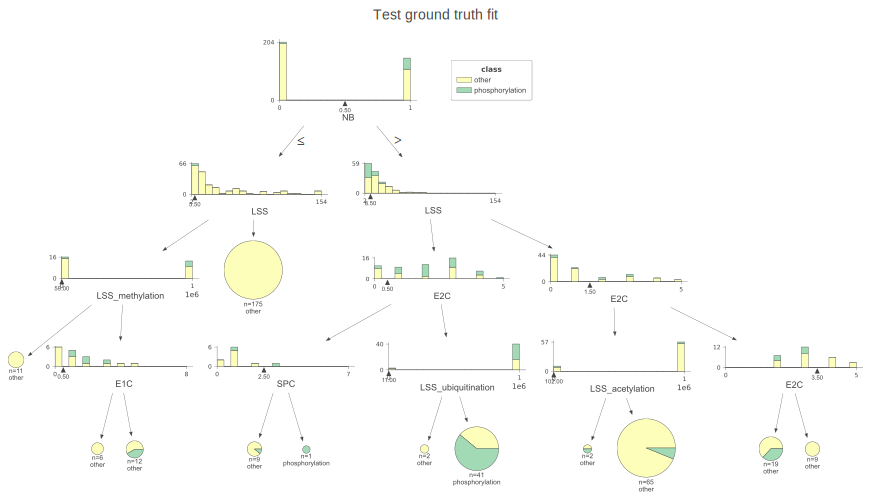

In [25]:
#plot_tree(result_test_gt[NAIVE_BAYES_WITH_TREE]["m"])

plot_tree_pretty(result_test_gt[NAIVE_BAYES_WITH_TREE]["m"], df_test["x"],
                 df_test["y"],"Test ground truth fit", "test_gt_fit_tree.svg")

### Test on train fit

In [26]:
result_train_predict_test_gt = predict_all_classifiers(df_test, train_result)

print_report_all_classifiers(df_test["y"], result_train_predict_test_gt,  all_labels)



0.26637554585152834
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.266

       z = 5.555
 p-value = 0.000

0.38235294117647056
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.382

       z = 7.288
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &             index & recall & f1-score & support &        cohen \\
\midrule
       Naive Bayes &      93.4 &          Negative &   78.2 &     85.2 &     308 &          NaN \\
       Naive Bayes &      28.7 &   Phosphorylation &   61.4 &     39.1 &      44 &          NaN \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &       Acetylation &    0.0

,model,precision,index,recall,f1-score,support,cohen
Negative,Naive Bayes,0.934109,Negative,0.782468,0.851590,308.0,NaN
Phosphorylation,Naive Bayes,0.287234,Phosphorylation,0.613636,0.391304,44.0,NaN
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0,NaN
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0,NaN
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0,NaN
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0,NaN
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0,NaN
micro avg,Naive Bayes,0.761364,micro avg,0.761364,0.761364,352.0,NaN
macro avg,Naive Bayes,0.174478,macro avg,0.199443,0.177556,352.0,NaN
weighted avg,Naive Bayes,0.853249,weighted avg,0.761364,0.794054,352.0,NaN


In [27]:
load_valtest_ensemble_pred(test_predictions_file).groupby("prediction").size()

prediction
acetylation            1
dephosphorylation      2
methylation            4
other                321
phosphorylation       24
dtype: int64

In [28]:
load_valtest_ensemble_pred(test_predictions_file).groupby("y").size()

y
0    321
1     24
2      2
3      4
5      1
dtype: int64

In [29]:
load_valtest_ensemble_pred(test_predictions_file).groupby("y_raw").size()

y_raw
acetylation            1
dephosphorylation      2
methylation            4
other                321
phosphorylation       24
dtype: int64

In [30]:
load_valtest_ensemble_pred(test_predictions_file).groupby("class").size()

class
acetylation            1
dephosphorylation      6
methylation            4
other                296
phosphorylation       44
ubiquitination         1
dtype: int64

In [31]:
load_valtest_ensemble_pred(test_predictions_file).pipe(transform_ovr).groupby("y").size()

y
0    328
1     24
dtype: int64

### Predict Test on Test Prediction fit 

In [32]:
df_test_prediction = load_valtest_ensemble_pred(test_predictions_file).pipe(transform_ovr)

result_test_bp = train_and_predict_all_classifiers(df_test_prediction, min_df=1)

print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)

print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)



l_test_pred =  print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)


Training Naive Bayes
Max words :  149
Training Naive Bayes + Tree
Max words :  149
Extracting features..for 352
Completed..
0.251588785046729
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.252

       z = 6.928
 p-value = 0.000

0.7317073170731707
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.732

       z = 13.728
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &             index & recall & f1-score & support &        cohen \\
\midrule
       Naive Bayes &      20.4 &   Phosphorylation &   95.8 &     33.6 &      24 &          NaN \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &    

In [33]:
compute_kappa(df_test_prediction["y"], 
                                  result_test_bp[NAIVE_BAYES_WITH_TREE]["predictions"]
                                  )

0.7317073170731707
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.732

       z = 13.728
 p-value = 0.000



{'python_kappa': 0.7317073170731707,
 'r_kappa': 0.731707317073171,
 'r_pvalue': 0.0}

In [34]:
compute_kappa(df_test_prediction["y"],
                                  result_test_bp[NAIVE_BAYES]["predictions"]
                                  )

0.251588785046729
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.252

       z = 6.928
 p-value = 0.000



{'python_kappa': 0.251588785046729,
 'r_kappa': 0.2515887850467289,
 'r_pvalue': 4.274136600201928e-12}

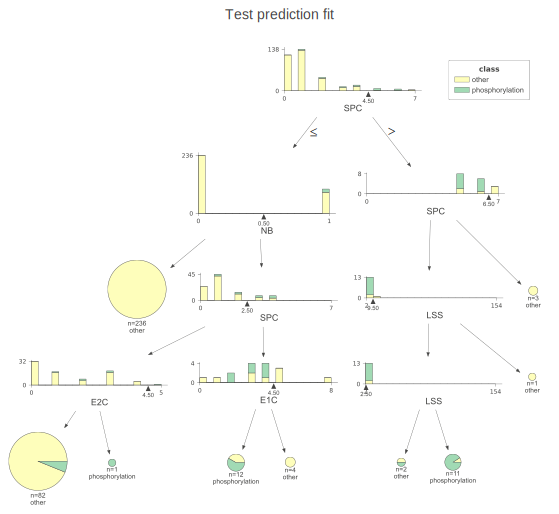

In [35]:
# plot_tree(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"])
plot_tree_pretty(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"], 
                 df_test_prediction["x"], 
                 df_test_prediction["y"], "Test prediction fit", "test_prediction_treeplot.svg")

In [36]:
t = l_test_pred.merge(l_test_gt,  on =["model", "index"])

print(t.to_latex(index=False, float_format= lambda x: f"{x:.1%}").replace("\%",""))

\begin{tabular}{lrlrrrrrrrrr}
\toprule
             model &  precision\_x &             index &  recall\_x &  f1-score\_x &  support\_x &  cohen\_x &  precision\_y &  recall\_y &  f1-score\_y &  support\_y &  cohen\_y \\
\midrule
       Naive Bayes &        20.4 &   Phosphorylation &     95.8 &       33.6 &    2400.0 &      NaN &        26.4 &     88.6 &       40.6 &    4400.0 &      NaN \\
       Naive Bayes &         0.0 & Dephosphorylation &      0.0 &        0.0 &       0.0 &      NaN &         0.0 &      0.0 &        0.0 &       0.0 &      NaN \\
       Naive Bayes &         0.0 &       Methylation &      0.0 &        0.0 &       0.0 &      NaN &         0.0 &      0.0 &        0.0 &       0.0 &      NaN \\
       Naive Bayes &         0.0 &    Ubiquitination &      0.0 &        0.0 &       0.0 &      NaN &         0.0 &      0.0 &        0.0 &       0.0 &      NaN \\
       Naive Bayes &         0.0 &       Acetylation &      0.0 &        0.0 &       0.0 &      NaN &         0.0 

In [37]:
df_test_prediction

,x,y,y_raw,prediction,class,confidence
0,Cellular responses to DNA damage require the f...,0,other,other,phosphorylation,0.996261
1,Cellular responses to DNA damage require the f...,1,phosphorylation,phosphorylation,phosphorylation,0.538010
2,PRTIG0 is a key activator of inflammatory and ...,0,other,other,methylation,0.438242
3,PROTPART0-specific activity has been reported ...,0,other,other,dephosphorylation,0.435728
4,Maintenance of chromosomal stability relies on...,0,other,other,phosphorylation,0.701883
...,...,...,...,...,...,...
347,Protein phosphorylation by kinases plays a cen...,0,other,other,other,0.997738
348,We previously demonstrated that when arsenic t...,0,other,other,other,0.812061
349,We previously demonstrated that when arsenic t...,0,other,other,other,0.996060
350,We previously demonstrated that when arsenic t...,1,phosphorylation,phosphorylation,other,0.962619


### Test prediction on train fit

In [38]:
result_train_predict_test_bp = predict_all_classifiers(df_test_prediction, train_result)

print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)



0.3233743409490335
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.323

       z = 8.050
 p-value = 0.000

0.4095238095238095
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.410

       z = 7.799
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &             index & recall & f1-score & support &        cohen \\
\midrule
       Naive Bayes &      99.6 &          Negative &   79.0 &     88.1 &     328 &          NaN \\
       Naive Bayes &      25.0 &   Phosphorylation &   95.8 &     39.7 &      24 &          NaN \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &

,model,precision,index,recall,f1-score,support,cohen
Negative,Naive Bayes,0.996154,Negative,0.789634,0.880952,328.0,NaN
Phosphorylation,Naive Bayes,0.250000,Phosphorylation,0.958333,0.396552,24.0,NaN
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0,NaN
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0,NaN
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0,NaN
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0,NaN
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0,NaN
micro avg,Naive Bayes,0.801136,micro avg,0.801136,0.801136,352.0,NaN
macro avg,Naive Bayes,0.178022,macro avg,0.249710,0.182501,352.0,NaN
weighted avg,Naive Bayes,0.945280,weighted avg,0.801136,0.847925,352.0,NaN


## Fit large scale Negative high quality

In [39]:
def random_sample_runs(df):
    result = []
    raw_predictions = []


    for i in [43, 100, 250, 289, 1, 95, 88, 1023, 10000, 38]:
        df_largescale_negative_sample_hq = pd.concat([df.query("y==0").sample(n=5000, random_state=i),
                                                  df.query("y==1")])
        result_largescale_negative_sample_hq  = train_and_predict_all_classifiers(df_largescale_negative_sample_hq)

        k_score = sklearn.metrics.cohen_kappa_score(df_largescale_negative_sample_hq["y"],
                                      result_largescale_negative_sample_hq[NAIVE_BAYES_WITH_TREE]["predictions"]
                                      )

        r = print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_largescale_negative_sample_hq, [1])
        r = r.query("index == 'Phosphorylation'").copy()
        r["kohenskappa"] = r["model"].apply(lambda x: 
                                   sklearn.metrics.cohen_kappa_score(df_largescale_negative_sample_hq["y"],
                                    result_largescale_negative_sample_hq[x]["predictions"]
                                      ))
        
        result.append(r)
        raw_predictions.append({"result":result_largescale_negative_sample_hq, 
                                "df": df_largescale_negative_sample_hq})

    return pd.concat(result), raw_predictions



In [40]:
%%time 


local_hq_file= os.path.join(temp_dir, s3_large_scale_high_q.split("/")[-1])

download_file(s3_large_scale_high_q , temp_dir)

df_largescale_multiple_random_runs, raw_predictions_random = random_sample_runs(load_large_scale(local_hq_file))


Training Naive Bayes
Max words :  134
Training Naive Bayes + Tree
Max words :  134
Extracting features..for 5269
Completed..
0.7636638310994546
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 5269
  Raters = 2
   Kappa = 0.764

       z = 56.359
 p-value = 0.000

0.8470666859199909
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 5269
  Raters = 2
   Kappa = 0.847

       z = 61.509
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &           index & recall & f1-score & support &    cohen \\
\midrule
       Naive Bayes &      66.5 & Phosphorylation &   93.7 &     77.8 &     269 &      NaN \\
       Naive Bayes &      66.5 &       micro avg &   93.7 &     77.8 &     269 &      NaN \\
       Naive Bayes &      66.5 &       macro avg &   93.7 &     77.8 &     269 &      NaN \\
       Naive Bayes &      66.5 &    weighted avg &   93.7 &     77.8 &     269 &      NaN \\
       Naive Bayes &       NaN &    python\_kappa &    NaN & 

Training Naive Bayes
Max words :  133
Training Naive Bayes + Tree
Max words :  133
Extracting features..for 5269
Completed..
0.7708092071959508
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 5269
  Raters = 2
   Kappa = 0.771

       z = 56.772
 p-value = 0.000

0.8505423582208199
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 5269
  Raters = 2
   Kappa = 0.851

       z = 61.868
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &           index & recall & f1-score & support &    cohen \\
\midrule
       Naive Bayes &      67.7 & Phosphorylation &   93.3 &     78.4 &     269 &      NaN \\
       Naive Bayes &      67.7 &       micro avg &   93.3 &     78.4 &     269 &      NaN \\
       Naive Bayes &      67.7 &       macro avg &   93.3 &     78.4 &     269 &      NaN \\
       Naive Bayes &      67.7 &    weighted avg &   93.3 &     78.4 &     269 &      NaN \\
       Naive Bayes &       NaN &    python\_kappa &    NaN & 

Training Naive Bayes
Max words :  134
Training Naive Bayes + Tree
Max words :  134
Extracting features..for 5269
Completed..
0.7636638310994546
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 5269
  Raters = 2
   Kappa = 0.764

       z = 56.359
 p-value = 0.000

0.8475107125770818
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 5269
  Raters = 2
   Kappa = 0.848

       z = 61.577
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &           index & recall & f1-score & support &    cohen \\
\midrule
       Naive Bayes &      66.5 & Phosphorylation &   93.7 &     77.8 &     269 &      NaN \\
       Naive Bayes &      66.5 &       micro avg &   93.7 &     77.8 &     269 &      NaN \\
       Naive Bayes &      66.5 &       macro avg &   93.7 &     77.8 &     269 &      NaN \\
       Naive Bayes &      66.5 &    weighted avg &   93.7 &     77.8 &     269 &      NaN \\
       Naive Bayes &       NaN &    python\_kappa &    NaN & 

In [41]:
df_largescale_multiple_random_runs

,model,precision,index,recall,f1-score,support,cohen,kohenskappa
Phosphorylation,Naive Bayes,0.664908,Phosphorylation,0.936803,0.777778,269.0,NaN,0.763664
Phosphorylation,Naive Bayes + Tree,0.833922,Phosphorylation,0.877323,0.855072,269.0,NaN,0.847067
Phosphorylation,Naive Bayes,0.692308,Phosphorylation,0.936803,0.796209,269.0,NaN,0.783496
Phosphorylation,Naive Bayes + Tree,0.815331,Phosphorylation,0.869888,0.841727,269.0,NaN,0.832921
Phosphorylation,Naive Bayes,0.681081,Phosphorylation,0.936803,0.788732,269.0,NaN,0.775457
Phosphorylation,Naive Bayes + Tree,0.795666,Phosphorylation,0.955390,0.868243,269.0,NaN,0.860470
Phosphorylation,Naive Bayes,0.647668,Phosphorylation,0.929368,0.763359,269.0,NaN,0.748208
Phosphorylation,Naive Bayes + Tree,0.814815,Phosphorylation,0.899628,0.855124,269.0,NaN,0.846922
Phosphorylation,Naive Bayes,0.676550,Phosphorylation,0.933086,0.784375,269.0,NaN,0.770809
Phosphorylation,Naive Bayes + Tree,0.809211,Phosphorylation,0.914498,0.858639,269.0,NaN,0.850542


In [42]:
df_largescale_multiple_random_runs.groupby("model").describe().T

model              Naive Bayes  Naive Bayes + Tree
precision   count    10.000000           10.000000
            mean      0.671318            0.817506
            std       0.013009            0.014866
            min       0.647668            0.795666
            25%       0.664908            0.810612
            50%       0.672019            0.816140
            75%       0.679948            0.825377
            max       0.692308            0.843206
recall      count    10.000000           10.000000
            mean      0.935316            0.905948
            std       0.002599            0.028096
            min       0.929368            0.869888
            25%       0.934015            0.893123
            50%       0.936803            0.899628
            75%       0.936803            0.911710
            max       0.936803            0.955390
f1-score    count    10.000000           10.000000
            mean      0.781574            0.859056
            std       0.009453            0.008646
            min       0.763359            0.841727
            25%       0.777778            0.855085
            50%       0.782280            0.857127
            75%       0.787811            0.866656
            max       0.796209            0.870504
support     count    10.000000           10.000000
            mean    269.000000          269.000000
            std       0.000000            0.000000
            min     269.000000          269.000000
            25%     269.000000          269.000000
            50%     269.000000          269.000000
            75%     269.000000          269.000000
            max     269.000000          269.000000
cohen       count     0.000000            0.000000
            mean           NaN                 NaN
            std            NaN                 NaN
            min            NaN                 NaN
            25%            NaN                 NaN
            50%            NaN                 NaN
            75%            NaN                 NaN
            max            NaN                 NaN
kohenskappa count    10.000000           10.000000
            mean      0.767765            0.851069
            std       0.010158            0.009038
            min       0.748208            0.832921
            25%       0.763664            0.846958
            50%       0.768533            0.849027
            75%       0.774465            0.858898
            max       0.783496            0.863299

In [43]:
def display_random_runs( df) :
    r = df_largescale_multiple_random_runs.groupby("model").agg(
        mean_precision = ('precision', 'mean'),
        sem_precision = ('precision', 'sem'),
        mean_recall = ('recall', 'mean'),
        sem_recall = ('recall', 'sem'),
        mean_f1 = ('f1-score', 'mean'),
        sem_f1 = ('f1-score', 'sem'),        
        mean_kappa = ('kohenskappa', 'mean'),
        sem_kappa = ('kohenskappa', 'sem'),  

        ).reset_index()
    
    r_latex = pd.DataFrame()
    
    r_latex["model"] = r["model"]
    r_latex["p"] =  r["mean_precision"].apply(lambda x: str(round(100*x,1))) + " (" \
                   + r["sem_precision"].apply(lambda x: str(round(100*x,1))) + ")"
    
    
    r_latex["r"] =  r["mean_recall"].apply(lambda x: str(round(100*x,1))) + " (" \
                   + r["sem_recall"].apply(lambda x: str(round(100*x,1))) + ")"
    
    
    
    r_latex["f"] =  r["mean_f1"].apply(lambda x: str(round(100*x,1))) + " (" \
                   + r["sem_f1"].apply(lambda x: str(round(100*x,1))) + ")"
    
    
    r_latex["k"] =  r["mean_kappa"].apply(lambda x: str(round(100*x,1))) + " (" \
                   + r["sem_kappa"].apply(lambda x: str(round(100*x,1))) + ")"
    return r_latex
    
display_random_runs(df_largescale_multiple_random_runs)

,model,p,r,f,k
0,Naive Bayes,67.1 (0.4),93.5 (0.1),78.2 (0.3),76.8 (0.3)
1,Naive Bayes + Tree,81.8 (0.5),90.6 (0.9),85.9 (0.3),85.1 (0.3)


In [44]:
print(display_random_runs(df_largescale_multiple_random_runs).to_latex(index=False))

\begin{tabular}{lllll}
\toprule
             model &          p &          r &          f &          k \\
\midrule
       Naive Bayes & 67.1 (0.4) & 93.5 (0.1) & 78.2 (0.3) & 76.8 (0.3) \\
Naive Bayes + Tree & 81.8 (0.5) & 90.6 (0.9) & 85.9 (0.3) & 85.1 (0.3) \\
\bottomrule
\end{tabular}



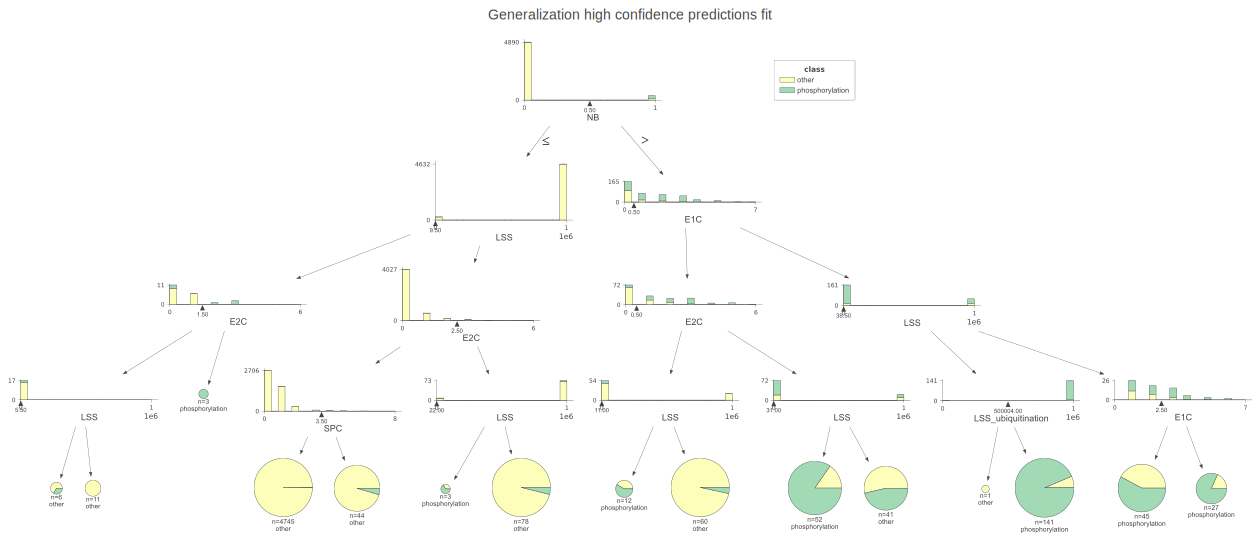

In [45]:
plot_tree_pretty(raw_predictions_random[0]["result"][NAIVE_BAYES_WITH_TREE]["m"], 
                 raw_predictions_random[0]["df"]["x"], 
                 raw_predictions_random[0]["df"]["y"],
                 "Generalization high confidence predictions fit", 
                 "largescale_hq_treeplot.svg")

## Latex results

In [49]:
def prepare_latex(meta_dict_df, index_filter=None ):#["micro avg"]
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        if index_filter:
            df = df[df["index"].isin(index_filter)].copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    
    # Drop index if just one ..
    if df["index"].nunique() ==1:
        df_summ = df_summ.drop("index", axis=1)
    
    return df_summ
    

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)





df_summ = prepare_latex ([
                {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},




                ],


              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format,
                                                  "recall":float_percent_format, 
                                                  "f1-score":float_percent_format,
                                                  "support":int_format,
                                                  "cohen":float_format
                                                 
                                                 }))

0.251588785046729
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.252

       z = 6.928
 p-value = 0.000

0.7317073170731707
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.732

       z = 13.728
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &             index & recall & f1-score & support &        cohen \\
\midrule
       Naive Bayes &      99.6 &          Negative &   72.6 &     84.0 &     328 &          NaN \\
       Naive Bayes &      20.4 &   Phosphorylation &   95.8 &     33.6 &      24 &          NaN \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &

In [47]:
df_summ_trainfit_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)
df_summ_trainfit_test_gt = print_report_all_classifiers(df_test["y"], result_train_predict_test_gt,  all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)





df_summ_neg = prepare_latex ([
                    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},





                ],
    index_filter=["Negative"]
              )

print("**Negative***")
print(df_summ_neg.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

df_summ_phos = prepare_latex ([
                        {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},





                ],
    index_filter=["Phosphorylation"]
              )

print("**Phosphorylation***")

print(df_summ_phos.to_latex(index=False, formatters = {"precision": float_percent_format,
                                                       "recall":float_percent_format, 
                                                       "f1-score":float_percent_format,
                                                       "support":int_format,
                                                        "cohen":float_format
                                                      
                                                      }))

0.3233743409490335
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.323

       z = 8.050
 p-value = 0.000

0.4095238095238095
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.410

       z = 7.799
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &             index & recall & f1-score & support &        cohen \\
\midrule
       Naive Bayes &      99.6 &          Negative &   79.0 &     88.1 &     328 &          NaN \\
       Naive Bayes &      25.0 &   Phosphorylation &   95.8 &     39.7 &      24 &          NaN \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &


**Negative***
\begin{tabular}{lllrrrrr}
\toprule
dataset &  T & model & precision & recall & f1-score & support &  cohen \\
\midrule
 PTM TR & GT &    NB &      96.4 &   79.2 &     87.0 &    1166 &    NaN \\
 PTM TR & GT &    NT &      94.3 &   97.2 &     95.7 &    1166 &    NaN \\
 PTM TS & GT &    NB &      93.4 &   78.2 &     85.2 &     308 &    NaN \\
 PTM TS & GT &    NT &      91.6 &   95.1 &     93.3 &     308 &    NaN \\
 PTM TS & BP &    NB &      99.6 &   79.0 &     88.1 &     328 &    NaN \\
 PTM TS & BP &    NT &      96.6 &   93.9 &     95.2 &     328 &    NaN \\
\bottomrule
\end{tabular}

**Phosphorylation***
\begin{tabular}{lllrrrrr}
\toprule
dataset &  T & model & precision & recall & f1-score & support & cohen \\
\midrule
 PTM TR & GT &    NB &      30.2 &   75.5 &     43.1 &     139 &   NaN \\
 PTM TR & GT &    NT &      68.3 &   51.1 &     58.4 &     139 &   NaN \\
 PTM TS & GT &    NB &      28.7 &   61.4 &     39.1 &      44 &   NaN \\
 PTM TS & GT &    NT &      

In [48]:
def prepare_latex(meta_dict_df):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NBT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        df = df.copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    df_summ["index"] = df_summ["index"].apply(lambda x: label_names[int(x)] if isint(x) else x )
    
    return df_summ


df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)



df_summ = prepare_latex ([
                {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, 
                                                  "recall":float_percent_format, 
                                                  "f1-score":float_percent_format,
                                                  "support":int_format,
                                                  
                                                 "cohen":float_format
                                                 
                                                 }))

0.251588785046729
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.252

       z = 6.928
 p-value = 0.000

0.7317073170731707
   Cohen's Kappa for 2 Raters (Weights: equal)    
Subjects = 352
  Raters = 2
   Kappa = 0.732

       z = 13.728
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &             index & recall & f1-score & support &        cohen \\
\midrule
       Naive Bayes &      99.6 &          Negative &   72.6 &     84.0 &     328 &          NaN \\
       Naive Bayes &      20.4 &   Phosphorylation &   95.8 &     33.6 &      24 &          NaN \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 &          NaN \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &

\begin{tabular}{lllrlrrrr}
\toprule
dataset &  T & model & precision &             index & recall & f1-score & support & cohen \\
\midrule
 PTM TR & GT &    NB &      96.4 &          Negative &   79.2 &     87.0 &    1166 &   NaN \\
 PTM TR & GT &    NB &      30.2 &   Phosphorylation &   75.5 &     43.1 &     139 &   NaN \\
 PTM TR & GT &    NB &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 &   NaN \\
 PTM TR & GT &    NB &       0.0 &       Methylation &    0.0 &      0.0 &       0 &   NaN \\
 PTM TR & GT &    NB &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 &   NaN \\
 PTM TR & GT &    NB &       0.0 &       Acetylation &    0.0 &      0.0 &       0 &   NaN \\
 PTM TR & GT &    NB &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 &   NaN \\
 PTM TR & GT &    NB &      78.8 &         micro avg &   78.8 &     78.8 &    1305 &   NaN \\
 PTM TR & GT &    NB &      18.1 &         macro avg &   22.1 &     18.6 &    1305 &   NaN \\
 PTM TR & GT & 